This code is based off a simple idea: dirty lens artifacts are really only noticeable in regions of the image where changes in intensity are common. In most of my photos in Greece, this translates to the blue sky or Aegean Sea. Thus, if we just apply a simple median filter to regions where most pixels are the same color, then we will vastly improve the images while not creating more artifacts (blur).

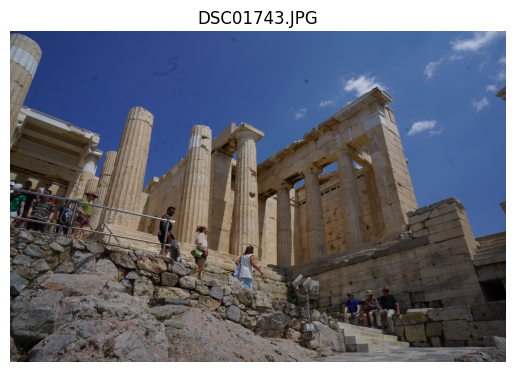

In [26]:
# this is running on my home server.. and I want to directly edit the images and replace them. Thus, I will grab an absolute path to the images:

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import numpy as np

image_path = '/home/tars/Media/t9_mnt/Pictures/DCIM/100MSDCF'

test_filename = 'DSC01743.JPG'  # testing photo

test_filepath = os.path.join(image_path, test_filename)

if os.path.isfile(test_filepath):
    img_bgr = cv2.imread(test_filepath)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(test_filename)
    plt.show()
else:
    print(f"Image file '{test_filename}' not found in directory.")


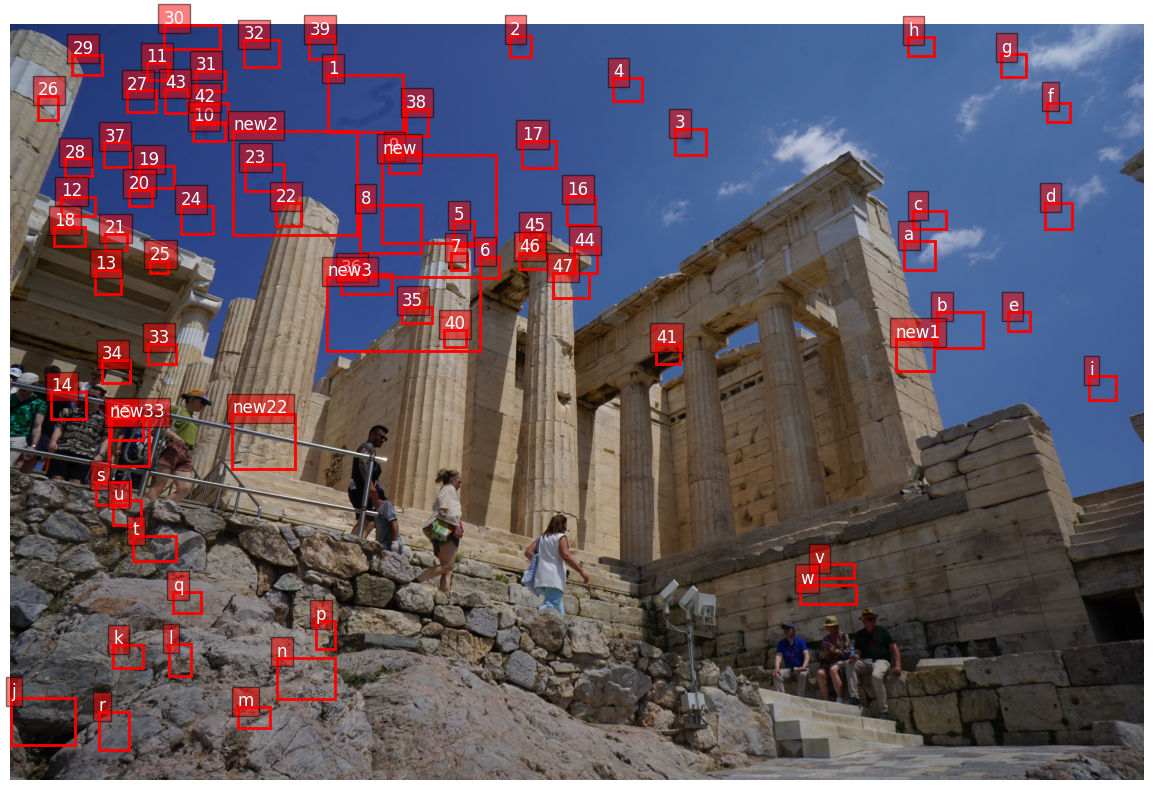

In [27]:
# 1) figure out the exact regions of the image that display the lens artifacts.. save these regions in a csv

# Load the bounding box labels
labels = pd.read_csv("labels.csv")

# Display image and overlay bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img_rgb)

for _, row in labels.iterrows():
    rect = patches.Rectangle(
        (row['bbox_x'], row['bbox_y']),  # (x, y)
        row['bbox_width'],               # width
        row['bbox_height'],              # height
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(row['bbox_x'], row['bbox_y'] - 5, str(row['label_name']), color='white', fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5))

plt.axis('off')
plt.tight_layout()
plt.show()

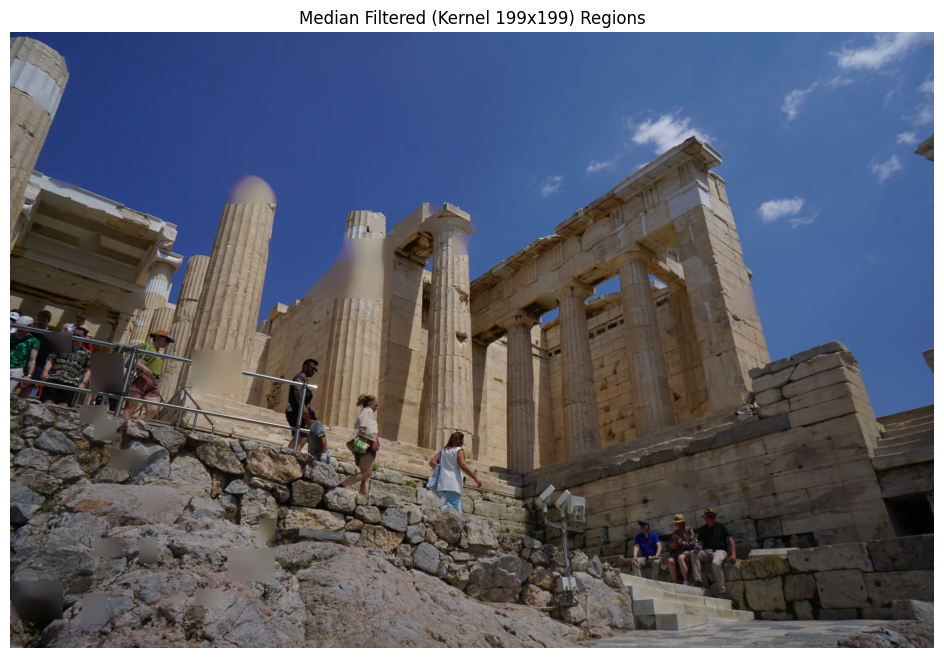

In [28]:
# 2) now, for each specific region, we should try a few different things.. start with a median filter

def clean_photo_median(image,kernel_size):

    img_filtered = image.copy()
        
    # Apply median filter to each region
    for _, row in labels.iterrows():
        x, y = int(row["bbox_x"]), int(row["bbox_y"])
        w, h = int(row["bbox_width"]), int(row["bbox_height"])
        
        # Extract region
        region = img_filtered[y:y+h, x:x+w]
    
        # Apply median filter to each channel
        filtered_region = np.zeros_like(region)
        for c in range(3):  # RGB channels
            filtered_region[..., c] = cv2.medianBlur(region[..., c], kernel_size)
    
        # Replace region in image
        img_filtered[y:y+h, x:x+w] = filtered_region

    return img_filtered


img = clean_photo_median(img_rgb,199)

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Median Filtered (Kernel {199}x{199}) Regions')
plt.show()

See how this leaves large patches of blurred artifacts?

In [32]:
def clean_photo_median_if_low_variance(image, labels, kernel_size=199, variance_threshold=20):
    img_filtered = image.copy()

    for _, row in labels.iterrows():
        x, y = int(row["bbox_x"]), int(row["bbox_y"])
        w, h = int(row["bbox_width"]), int(row["bbox_height"])
        
        region = img_filtered[y:y+h, x:x+w]

        # Compute per-channel variance, then mean across channels
        variance = np.var(region.astype(np.float32), axis=(0, 1)).mean()

        if variance < variance_threshold:
            # print(f"Applying filter at ({x},{y},{w},{h}) — variance={variance:.2f}")
            filtered_region = np.zeros_like(region)
            for c in range(3):
                filtered_region[..., c] = cv2.medianBlur(region[..., c], kernel_size)
            img_filtered[y:y+h, x:x+w] = filtered_region
        else:
            None
            # print(f"Skipping region at ({x},{y},{w},{h}) — variance={variance:.2f}")

    return img_filtered


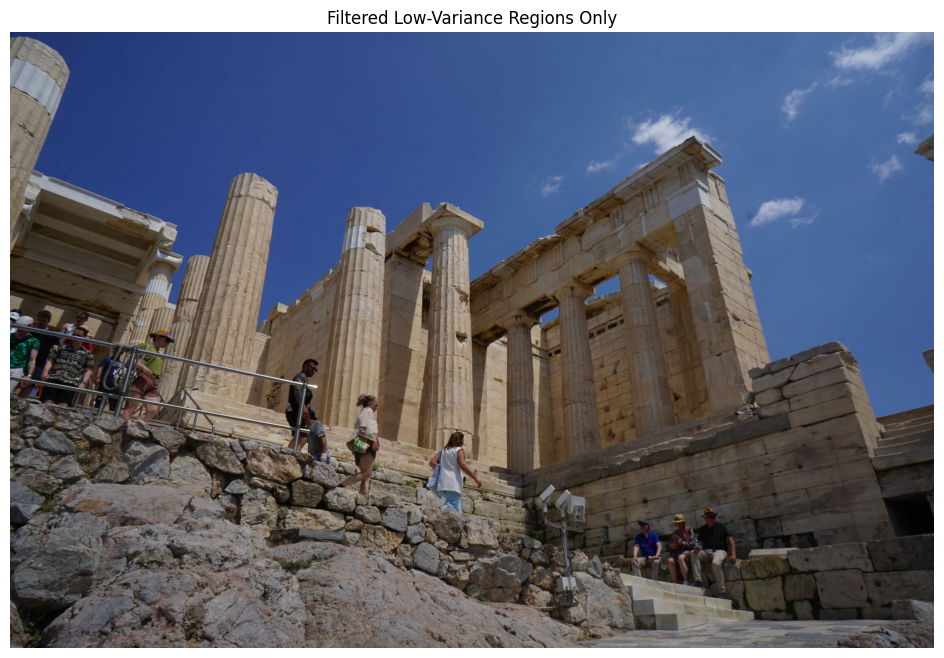

In [33]:
img = clean_photo_median_if_low_variance(img_rgb, labels_filtered, kernel_size=199, variance_threshold=50)

plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Filtered Low-Variance Regions Only')
plt.show()

Much better!

In [34]:
# 3) go from DSC01913.JPG to DSC01692.JPG - go in and apply the median filter, and save a copy as ".._edit.JPG"

image_path = '/home/tars/Media/t9_mnt/Pictures/DCIM/100MSDCF'

# Create the filename list
start_num = 1913 # had to stop and start because some images were vertical. Started at 1913 originally
end_num = 1692 - 1  # inclusive
for num in range(start_num, end_num, -1):
    filename = f"DSC0{num:04d}.JPG"
    full_path = os.path.join(image_path, filename)

    if not os.path.exists(full_path):
        print(f"Skipping missing file: {filename}")
        continue

    img_rgb = cv2.imread(full_path)
    if img_rgb is None:
        print(f"Could not read {filename}")
        continue
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

    # Apply median variance based filter
    filtered_img = clean_photo_median_if_low_variance(img_rgb, labels, kernel_size=199, variance_threshold=50)

    # Convert back to BGR for OpenCV savingthe
    filtered_bgr = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR)

    # Save with _edit.JPG
    save_name = filename.replace(".JPG", "_edit.JPG")
    save_path = os.path.join(image_path, save_name)
    cv2.imwrite(save_path, filtered_bgr)
    print(f"Saved {save_name}")

Saved DSC01913_edit.JPG
Saved DSC01912_edit.JPG
Saved DSC01911_edit.JPG
Saved DSC01910_edit.JPG
Saved DSC01909_edit.JPG
Saved DSC01908_edit.JPG
Saved DSC01907_edit.JPG
Saved DSC01906_edit.JPG
Saved DSC01905_edit.JPG
Saved DSC01904_edit.JPG
Saved DSC01903_edit.JPG
Saved DSC01902_edit.JPG
Saved DSC01901_edit.JPG
Saved DSC01900_edit.JPG
Saved DSC01899_edit.JPG
Saved DSC01898_edit.JPG
Saved DSC01897_edit.JPG
Saved DSC01896_edit.JPG
Saved DSC01895_edit.JPG
Saved DSC01894_edit.JPG
Saved DSC01893_edit.JPG
Saved DSC01892_edit.JPG
Saved DSC01891_edit.JPG
Saved DSC01890_edit.JPG
Saved DSC01889_edit.JPG
Saved DSC01888_edit.JPG
Saved DSC01887_edit.JPG
Saved DSC01886_edit.JPG
Saved DSC01885_edit.JPG
Saved DSC01884_edit.JPG
Saved DSC01883_edit.JPG
Saved DSC01882_edit.JPG
Saved DSC01881_edit.JPG
Saved DSC01880_edit.JPG
Saved DSC01879_edit.JPG
Saved DSC01878_edit.JPG
Saved DSC01877_edit.JPG
Saved DSC01876_edit.JPG
Saved DSC01875_edit.JPG
Saved DSC01874_edit.JPG
Saved DSC01873_edit.JPG
Saved DSC01872_e

/home/tars/jupyter/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/tars/jupyter/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/tars/jupyter/lib/python3.12/site-packages/numpy/_core/_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Saved DSC01826_edit.JPG
Saved DSC01825_edit.JPG
Saved DSC01824_edit.JPG
Saved DSC01823_edit.JPG
Saved DSC01822_edit.JPG
Saved DSC01821_edit.JPG
Saved DSC01820_edit.JPG
Saved DSC01819_edit.JPG
Saved DSC01818_edit.JPG
Saved DSC01817_edit.JPG
Saved DSC01816_edit.JPG
Saved DSC01815_edit.JPG
Saved DSC01814_edit.JPG
Saved DSC01813_edit.JPG
Saved DSC01812_edit.JPG
Saved DSC01811_edit.JPG
Saved DSC01810_edit.JPG
Saved DSC01809_edit.JPG
Saved DSC01808_edit.JPG
Saved DSC01807_edit.JPG
Saved DSC01806_edit.JPG
Saved DSC01805_edit.JPG
Saved DSC01804_edit.JPG
Saved DSC01803_edit.JPG
Saved DSC01802_edit.JPG
Saved DSC01801_edit.JPG
Saved DSC01800_edit.JPG
Saved DSC01799_edit.JPG
Saved DSC01798_edit.JPG
Saved DSC01797_edit.JPG
Saved DSC01796_edit.JPG
Saved DSC01795_edit.JPG
Saved DSC01794_edit.JPG
Saved DSC01793_edit.JPG
Saved DSC01792_edit.JPG
Saved DSC01791_edit.JPG
Saved DSC01790_edit.JPG
Saved DSC01789_edit.JPG
Saved DSC01788_edit.JPG
Saved DSC01787_edit.JPG
Saved DSC01786_edit.JPG
Saved DSC01785_e

In [37]:
# final step - copy the metadata of the non-edit photos to the edit photos. Thanks GPT!

import piexif
from PIL import Image

def copy_exif_to_edits(directory):
    for filename in os.listdir(directory):
        if filename.endswith('_edit.JPG'):
            edit_path = os.path.join(directory, filename)
            original_name = filename.replace('_edit', '')
            original_path = os.path.join(directory, original_name)

            if os.path.exists(original_path):
                try:
                    # Load EXIF from original
                    original_img = Image.open(original_path)
                    exif_dict = piexif.load(original_img.info.get("exif", b""))

                    # Load edited image
                    edit_img = Image.open(edit_path)

                    # Save edited image with original EXIF
                    exif_bytes = piexif.dump(exif_dict)
                    edit_img.save(edit_path, exif=exif_bytes)

                    print(f"✅ Copied EXIF from {original_name} → {filename}")
                except Exception as e:
                    print(f"❌ Failed on {filename}: {e}")
            else:
                print(f"⚠️ No original found for {filename}")

# Example usage
copy_exif_to_edits('/home/tars/Media/t9_mnt/Pictures/DCIM/100MSDCF')


✅ Copied EXIF from DSC01913.JPG → DSC01913_edit.JPG
✅ Copied EXIF from DSC01912.JPG → DSC01912_edit.JPG
✅ Copied EXIF from DSC01911.JPG → DSC01911_edit.JPG
✅ Copied EXIF from DSC01910.JPG → DSC01910_edit.JPG
✅ Copied EXIF from DSC01909.JPG → DSC01909_edit.JPG
✅ Copied EXIF from DSC01908.JPG → DSC01908_edit.JPG
✅ Copied EXIF from DSC01907.JPG → DSC01907_edit.JPG
✅ Copied EXIF from DSC01906.JPG → DSC01906_edit.JPG
✅ Copied EXIF from DSC01905.JPG → DSC01905_edit.JPG
✅ Copied EXIF from DSC01904.JPG → DSC01904_edit.JPG
✅ Copied EXIF from DSC01903.JPG → DSC01903_edit.JPG
✅ Copied EXIF from DSC01902.JPG → DSC01902_edit.JPG
✅ Copied EXIF from DSC01901.JPG → DSC01901_edit.JPG
✅ Copied EXIF from DSC01900.JPG → DSC01900_edit.JPG
✅ Copied EXIF from DSC01899.JPG → DSC01899_edit.JPG
✅ Copied EXIF from DSC01898.JPG → DSC01898_edit.JPG
✅ Copied EXIF from DSC01897.JPG → DSC01897_edit.JPG
✅ Copied EXIF from DSC01896.JPG → DSC01896_edit.JPG
✅ Copied EXIF from DSC01895.JPG → DSC01895_edit.JPG
✅ Copied EXI

Final thoughts: while this method is not perfect, and the outcome varies greatly on the type of photo taken (how far I was from the subject, how much sky is in the photo, etc) this worked well enough for now for the over 200 photos I took on the date where my lens was dirty. 